In [1]:
!pip install -q -U transformers
!pip install -q accelerate
!pip install -q -U accelerate
!pip install -q trl
!pip install -q peft
!pip install -q bitsandbytes

In [2]:
from transformers import BitsAndBytesConfig
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,  # Reduce compute to half precision for speed/memory
    bnb_4bit_use_double_quant=True,  # Apply double quantization for further compression
    bnb_4bit_quant_type="nf4",  # Use non-negative matrix factorization (NF4) for better accuracy
)

# Model ID for Llava
model_id = "llava-hf/llava-1.5-13b-hf"

# Load the processor and model with the new configuration
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    device_map="auto"
)

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/77.2k [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

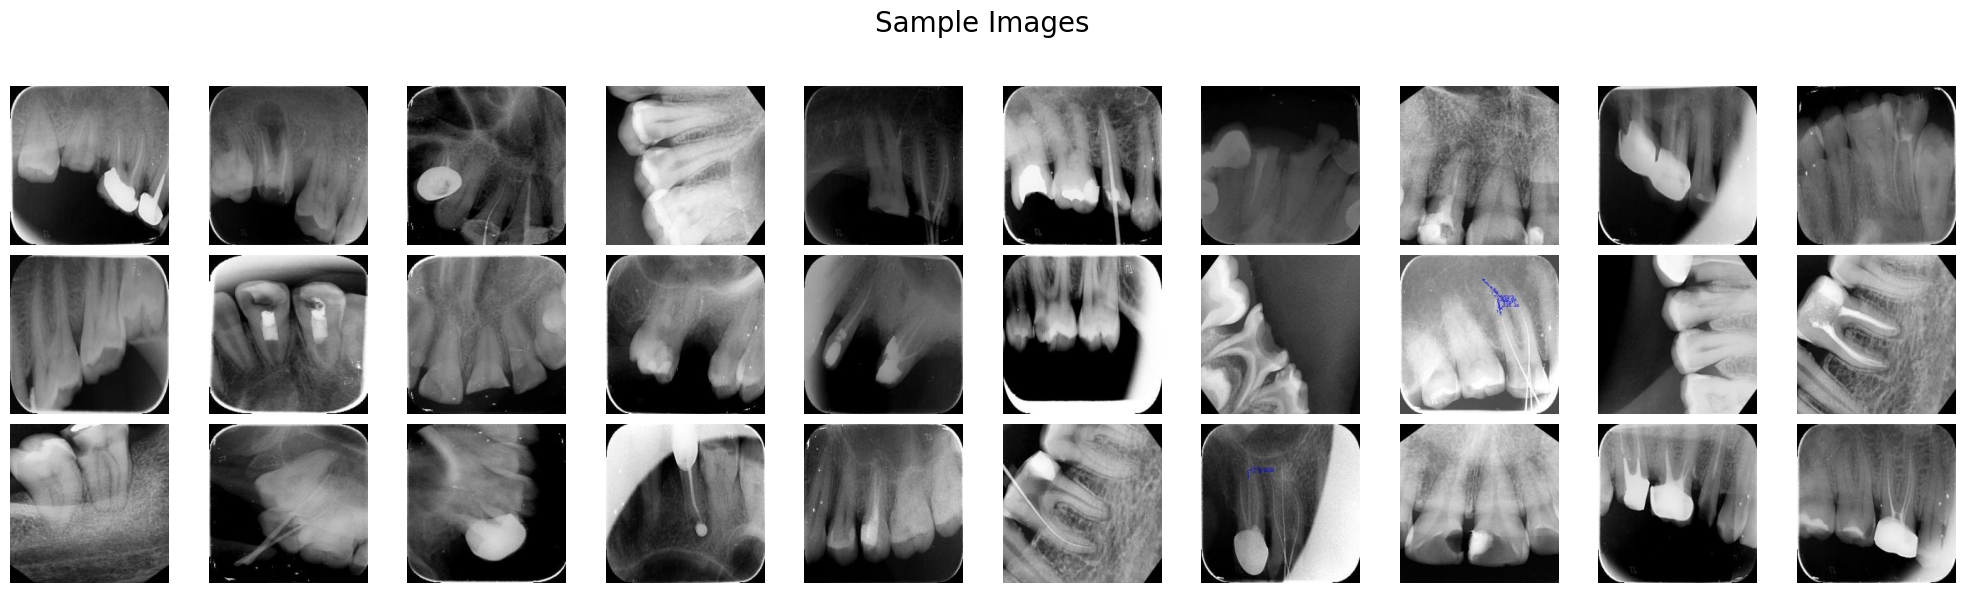

In [3]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the dataset directory
dataset_dir = '/kaggle/input/d/mahirafser/llava-inference/root-canal-captioning/valid'  # Adjust this path based on your directory structure

# List all files in the dataset directory
all_files = os.listdir(dataset_dir)
# Filter out only image files (assuming they have common image extensions)
image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

# Randomly select 30 image files to display
sample_files = random.sample(image_files, 30)

# Create a 3x10 grid for displaying images
fig, axes = plt.subplots(3, 10, figsize=(20, 6))
axes = axes.flatten()  # Flatten the array of axes for easy iteration

# Load and display the images
for i, file_name in enumerate(sample_files):
    image_path = os.path.join(dataset_dir, file_name)
    image = Image.open(image_path)

    # Plot the image
    axes[i].imshow(image)
    axes[i].axis('off')

# Hide any remaining empty subplots (in case there are fewer than 30 images)
for j in range(len(sample_files), len(axes)):
    axes[j].axis('off')

# Add a big title to the entire grid
fig.suptitle("Sample Images", fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
plt.show()


In [4]:
import os
from PIL import Image
import torch
from transformers import AutoProcessor

# Define the path to the dataset directory
dataset_dir = '/kaggle/input/d/mahirafser/llava-inference/root-canal-captioning/valid'  # Adjust this path based on your directory structure

# List all files in the dataset directory
all_files = os.listdir(dataset_dir)
# Filter out only image files (assuming they have common image extensions)
image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

# Load all images
images = []
for file_name in image_files:
    image_path = os.path.join(dataset_dir, file_name)
    image = Image.open(image_path)
    images.append(image)

# Define the prompts
prompts = [ """ USER: <image> Analyze the root canal treatment status across various 
sections of the image, identifying whether each area is complete, incomplete, or 
in need of further intervention. Use concise descriptions to convey the overall 
treatment status effectively, limiting it to 2-3 sentences.\nASSISTANT: """
] * len(images)  # Replicate the prompt for each image

# Process all images with the prompts
inputs = processor(text=prompts, images=images, padding=True, return_tensors="pt").to("cuda")

# Print the shapes of the input tensors
for k, v in inputs.items():
    print(k, v.shape)

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


input_ids torch.Size([139, 78])
attention_mask torch.Size([139, 78])
pixel_values torch.Size([139, 3, 336, 336])


In [5]:
"""from transformers import pipeline
# Create an image-to-text pipeline with quantization configuration
pipe = pipeline(
    "image-to-text",
    model=model_id,
    model_kwargs={"quantization_config": quantization_config}
)"""

'from transformers import pipeline\n# Create an image-to-text pipeline with quantization configuration\npipe = pipeline(\n    "image-to-text",\n    model=model_id,\n    model_kwargs={"quantization_config": quantization_config}\n)'

In [6]:
"""max_new_tokens = 200
prompt = "USER: <image>\nDescribe the status of root canal treatment in various areas with a single sentence, indicating whether each area is complete, incomplete, or requires further treatment.\nASSISTANT:"

# Process all images with the prompts using the pipeline
results = []
for image in images:
    output = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
    results.append(output[0]["generated_text"])

# Print the results
for result in results:
    print(result.split("ASSISTANT:")[-1].strip())"""

'max_new_tokens = 200\nprompt = "USER: <image>\nDescribe the status of root canal treatment in various areas with a single sentence, indicating whether each area is complete, incomplete, or requires further treatment.\nASSISTANT:"\n\n# Process all images with the prompts using the pipeline\nresults = []\nfor image in images:\n    output = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})\n    results.append(output[0]["generated_text"])\n\n# Print the results\nfor result in results:\n    print(result.split("ASSISTANT:")[-1].strip())'

In [7]:
from transformers import AutoProcessor, pipeline, BitsAndBytesConfig
# Create an image-to-text pipeline with quantization configuration
pipe = pipeline(
    "image-to-text",
    model=model_id,
    model_kwargs={"quantization_config": quantization_config}
)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
import os
import json
from PIL import Image
import torch
from transformers import AutoProcessor, pipeline, BitsAndBytesConfig
import matplotlib.pyplot as plt

# Define the path to the dataset directory and output file
dataset_dir = '/kaggle/input/d/mahirafser/llava-inference/root-canal-captioning/train'  # Adjust this path based on your directory structure
output_jsonl = '/kaggle/working/train.jsonl'

# List all files in the dataset directory
all_files = os.listdir(dataset_dir)
# Filter out only image files (assuming they have common image extensions)
image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

# Load and resize all images
images = []
max_size = (300, 300)  # Maximum size (width, height) for resizing

for file_name in image_files:
    image_path = os.path.join(dataset_dir, file_name)
    image = Image.open(image_path)
    image.thumbnail(max_size)  # Resize image to fit within max_size
    images.append((file_name, image))  # Store image name and image

# Define the prompt
prompt =  """ USER: <image> Analyze the root canal treatment status across various 
sections of the image, identifying whether each area is complete, incomplete, or 
in need of further intervention. Use concise descriptions to convey the overall 
treatment status effectively, limiting it to 2-3 sentences.\nASSISTANT: """

# Process all images with the prompts using the pipeline
results = []
for file_name, image in images:
    output = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
    caption = output[0]["generated_text"].split("ASSISTANT:")[-1].strip()
    results.append((file_name, caption))

# Write the results to a JSONL file
with open(output_jsonl, 'w') as f:
    for file_name, caption in results:
        # Write the JSON line in the required format
        entry = {
            "image": file_name,
            "prefix": "",
            "suffix": caption
        }
        f.write(json.dumps(entry) + '\n')  # Write each dictionary as a JSONL line

print(f"Captions saved to {output_jsonl}")

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Captions saved to /kaggle/working/train.jsonl


In [9]:
import os
import json
from PIL import Image
import torch
from transformers import AutoProcessor, pipeline, BitsAndBytesConfig
import matplotlib.pyplot as plt

# Define the path to the dataset directory and output file
dataset_dir = '/kaggle/input/d/mahirafser/llava-inference/root-canal-captioning/valid'  # Adjust this path based on your directory structure
output_jsonl = '/kaggle/working/valid.jsonl'

# List all files in the dataset directory
all_files = os.listdir(dataset_dir)
# Filter out only image files (assuming they have common image extensions)
image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

# Load and resize all images
images = []
max_size = (300, 300)  # Maximum size (width, height) for resizing

for file_name in image_files:
    image_path = os.path.join(dataset_dir, file_name)
    image = Image.open(image_path)
    image.thumbnail(max_size)  # Resize image to fit within max_size
    images.append((file_name, image))  # Store image name and image

# Define the prompt
prompt =  """ USER: <image> Analyze the root canal treatment status across various 
sections of the image, identifying whether each area is complete, incomplete, or 
in need of further intervention. Use concise descriptions to convey the overall 
treatment status effectively, limiting it to 2-3 sentences.\nASSISTANT: """
# Process all images with the prompts using the pipeline
results = []
for file_name, image in images:
    output = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
    caption = output[0]["generated_text"].split("ASSISTANT:")[-1].strip()
    results.append((file_name, caption))

# Write the results to a JSONL file
with open(output_jsonl, 'w') as f:
    for file_name, caption in results:
        # Write the JSON line in the required format
        entry = {
            "image": file_name,
            "prefix": "",
            "suffix": caption
        }
        f.write(json.dumps(entry) + '\n')  # Write each dictionary as a JSONL line

print(f"Captions saved to {output_jsonl}")

Captions saved to /kaggle/working/valid.jsonl


In [10]:
import os
import json
from PIL import Image
import torch
from transformers import AutoProcessor, pipeline, BitsAndBytesConfig
import matplotlib.pyplot as plt

# Define the path to the dataset directory and output file
dataset_dir = '/kaggle/input/d/mahirafser/llava-inference/root-canal-captioning/test'  # Adjust this path based on your directory structure
output_jsonl = '/kaggle/working/test.jsonl'

# List all files in the dataset directory
all_files = os.listdir(dataset_dir)
# Filter out only image files (assuming they have common image extensions)
image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

# Load and resize all images
images = []
max_size = (300, 300)  # Maximum size (width, height) for resizing

for file_name in image_files:
    image_path = os.path.join(dataset_dir, file_name)
    image = Image.open(image_path)
    image.thumbnail(max_size)  # Resize image to fit within max_size
    images.append((file_name, image))  # Store image name and image

# Define the prompt
prompt =  """ USER: <image> Analyze the root canal treatment status across various 
sections of the image, identifying whether each area is complete, incomplete, or 
in need of further intervention. Use concise descriptions to convey the overall 
treatment status effectively, limiting it to 2-3 sentences.\nASSISTANT: """
# Process all images with the prompts using the pipeline
results = []
for file_name, image in images:
    output = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
    caption = output[0]["generated_text"].split("ASSISTANT:")[-1].strip()
    results.append((file_name, caption))

# Write the results to a JSONL file
with open(output_jsonl, 'w') as f:
    for file_name, caption in results:
        # Write the JSON line in the required format
        entry = {
            "image": file_name,
            "prefix": "",
            "suffix": caption
        }
        f.write(json.dumps(entry) + '\n')  # Write each dictionary as a JSONL line

print(f"Captions saved to {output_jsonl}")

Captions saved to /kaggle/working/test.jsonl


In [11]:
import json
import re

# Path to the uploaded JSONL file
input_jsonl = '/kaggle/working/train.jsonl'
output_jsonl = '/kaggle/working/preprocessed_train.jsonl'

# Open the input file and prepare a list for cleaned entries
cleaned_entries = []

with open(input_jsonl, 'r') as file:
    for line in file:
        entry = json.loads(line)
        suffix = entry.get("suffix", "")
        if suffix:
            # Clean the suffix by removing unwanted characters, numbers, and extra spaces
            clean_suffix = re.sub(r'\d+[\.\,]*', '', suffix)  # Remove numbers like 1., 10., etc.
            clean_suffix = re.sub(r'\s+', ' ', clean_suffix).strip()  # Remove extra spaces and newlines
            entry["suffix"] = clean_suffix  # Update the entry with the cleaned suffix
            cleaned_entries.append(entry)

# Write the cleaned entries back to a new JSONL file
with open(output_jsonl, 'w') as f:
    for entry in cleaned_entries:
        f.write(json.dumps(entry) + '\n')  # Write each cleaned entry as a JSONL line

print(f"Cleaned JSONL file saved to {output_jsonl}")


Cleaned JSONL file saved to /kaggle/working/preprocessed_train.jsonl


In [12]:
import json
import re

# Path to the uploaded JSONL file
input_jsonl = '/kaggle/working/valid.jsonl'
output_jsonl = '/kaggle/working/preprocessed_valid.jsonl'

# Open the input file and prepare a list for cleaned entries
cleaned_entries = []

with open(input_jsonl, 'r') as file:
    for line in file:
        entry = json.loads(line)
        suffix = entry.get("suffix", "")
        if suffix:
            # Clean the suffix by removing unwanted characters, numbers, and extra spaces
            clean_suffix = re.sub(r'\d+[\.\,]*', '', suffix)  # Remove numbers like 1., 10., etc.
            clean_suffix = re.sub(r'\s+', ' ', clean_suffix).strip()  # Remove extra spaces and newlines
            entry["suffix"] = clean_suffix  # Update the entry with the cleaned suffix
            cleaned_entries.append(entry)

# Write the cleaned entries back to a new JSONL file
with open(output_jsonl, 'w') as f:
    for entry in cleaned_entries:
        f.write(json.dumps(entry) + '\n')  # Write each cleaned entry as a JSONL line

print(f"Cleaned JSONL file saved to {output_jsonl}")


Cleaned JSONL file saved to /kaggle/working/preprocessed_valid.jsonl


In [13]:
import json
import re

# Path to the uploaded JSONL file
input_jsonl = '/kaggle/working/test.jsonl'
output_jsonl = '/kaggle/working/preprocessed_test.jsonl'

# Open the input file and prepare a list for cleaned entries
cleaned_entries = []

with open(input_jsonl, 'r') as file:
    for line in file:
        entry = json.loads(line)
        suffix = entry.get("suffix", "")
        if suffix:
            # Clean the suffix by removing unwanted characters, numbers, and extra spaces
            clean_suffix = re.sub(r'\d+[\.\,]*', '', suffix)  # Remove numbers like 1., 10., etc.
            clean_suffix = re.sub(r'\s+', ' ', clean_suffix).strip()  # Remove extra spaces and newlines
            entry["suffix"] = clean_suffix  # Update the entry with the cleaned suffix
            cleaned_entries.append(entry)

# Write the cleaned entries back to a new JSONL file
with open(output_jsonl, 'w') as f:
    for entry in cleaned_entries:
        f.write(json.dumps(entry) + '\n')  # Write each cleaned entry as a JSONL line

print(f"Cleaned JSONL file saved to {output_jsonl}")


Cleaned JSONL file saved to /kaggle/working/preprocessed_test.jsonl
